Leage/Seasons with xG data:  
https://fbref.com/en/expected-goals-model-explained/#comps  
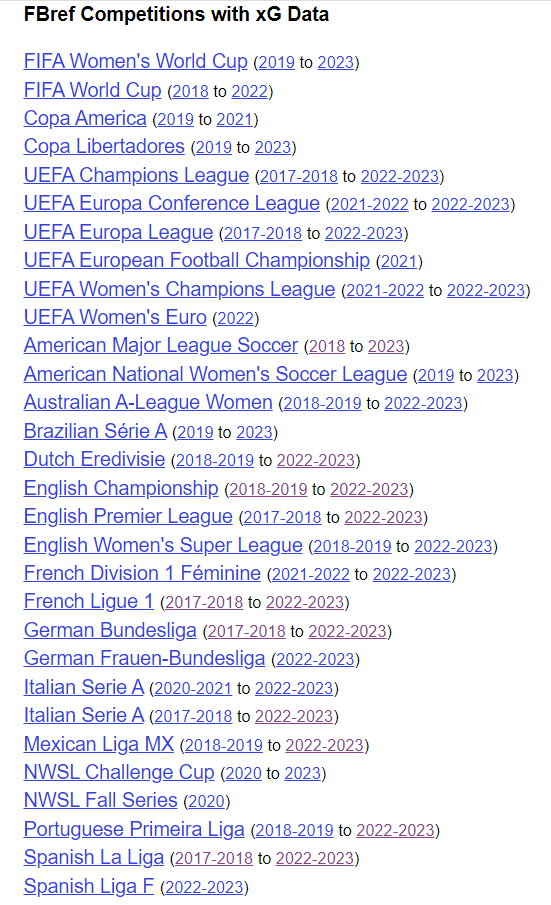

In [1]:
import httpx
import bs4
from dataclasses import dataclass, asdict
import unicodedata
import datetime as dt
import pandas as pd
import numpy as np
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', 100)

In [2]:
@dataclass
class Fixture:
    url: str = None
    home_team: str = None
    away_team: str = None
    datetime: int = None
    home_team_manager: str = None
    away_team_manager: str = None
    stadium: str = None
    attendance: int = None

In [3]:
def create_fixtures(season: str, competition_id: int, competition_name: str) -> list[Fixture]:
    url = f"https://fbref.com/en/comps/{competition_id}/{season}/schedule/{season}-{competition_name}-Scores-and-Fixtures"    
    
    # Send request
    with httpx.Client() as client:
        max_tries = 10
        tries = 0
        while tries < max_tries:
            try:
                resp = client.get(url)
                tries = 10
            except:
                tries += 1
                time.sleep(10)
#     with httpx.Client() as client:
#         resp = httpx.get(url)
    
    soup = bs4.BeautifulSoup(resp, "html.parser")
    
    # Get soup elements for score
    soup_table = soup.select("div.table_container")[0]
    soups_score = soup_table.find_all("td", attrs={"data-stat": "score"})
    soups_away_xg = soup_table.find_all("td", attrs={"data-stat": "away_xg"})
    
    # Add link to fixtures list
    fixtures = []
    for i in range(len(soups_score)):
        soup_score = soups_score[i]
        soup_away_xg = soups_away_xg[i]
        if soup_score["class"]==['center', 'iz']:  # is not fixture
            continue
        elif (soup_away_xg.text == ""):  # fixture does not have stats (happens rarely, for example when a match is voided)
            continue
        else:
            fixtures.append(Fixture(url="https://fbref.com" + soup_score.find("a")["href"]))
            
    return fixtures

In [4]:
def add_fixture_info(fixture: Fixture, soup: bs4.BeautifulSoup) -> Fixture:
    # Get soup for scorebox
    soup_scorebox = soup.find("div", {"class": "scorebox"})
    soup_home_scorebox = soup_scorebox.findChildren("div")[0]
    soup_away_scorebox = soup_home_scorebox.find_next_sibling("div")

    # Add fixture info
    fixture.home_team = soup_home_scorebox.select("div.media-item.logo")[0].findNext("strong").text.strip()
    fixture.away_team = soup_away_scorebox.select("div.media-item.logo")[0].findNext("strong").text.strip()
    
    fixture.home_team_manager = unicodedata.normalize("NFKD", soup_home_scorebox.find("div", {"class": "datapoint"}).text).split("Manager: ")[-1]
    fixture.away_team_manager = unicodedata.normalize("NFKD", soup_away_scorebox.find("div", {"class": "datapoint"}).text).split("Manager: ")[-1]
    
    soup_scorebox_meta = soup_scorebox.find("div", {"class": "scorebox_meta"}) 
    fixture.datetime = int(soup_scorebox_meta.find("span")["data-venue-epoch"])
    
    try: 
        fixture.attendance = int(soup_scorebox_meta.find_all("div")[4].text.split("Attendance: ")[-1].replace(",", ""))
        fixture.stadium = soup_scorebox_meta.find_all("div")[5].text.split("Venue: ")[-1]
    except:  # covid - no attendance
        fixture.attendance = 0
        fixture.stadium = soup_scorebox_meta.find_all("div")[4].text.split("Venue: ")[-1]
    
    return fixture

In [5]:
def parse_soup_table(fixture: Fixture, soup_table: bs4.BeautifulSoup) -> list[dict]:
    soup_table = soup_table.find("tbody")  # restrict table to tbody
    
    soup_table_rows = soup_table.find_all("tr")
    
    table_rows = []
    for soup_table_row in soup_table_rows:  # row in rows
        
        # filter out seperator rows
        if soup_table_row.has_attr("class"):
            if soup_table_row["class"] == ['spacer', 'partial_table']:  
                continue
                
        soup_table_row_columns = soup_table_row.find_all("td")
        soup_table_row_columns.append(soup_table_row.find("th"))
        
        table_row = {"home_team": fixture.home_team, "away_team": fixture.away_team, "datetime": fixture.datetime}
        for soup_table_row_column in soup_table_row_columns:  # columns in row
            data_stat = soup_table_row_column["data-stat"]
            
            # if player, take player-id
            if data_stat.endswith("player"):
                if soup_table_row_column.find("a"):
                    table_row[f"{data_stat}_id"] = soup_table_row_column.find("a")["href"].split("/")[-2]
                else:
                    table_row[f"{data_stat}_id"] = ""
                    
            table_row[data_stat] = soup_table_row_column.text
            
        table_rows.append(table_row)

    return table_rows

In [6]:
# main

In [7]:
def scrape(fixture: Fixture, soup: bs4.BeautifulSoup) -> tuple:

    print(fixture.url)
    
    # Get Fixture specific info
    fixture = add_fixture_info(fixture, soup)

    # Get all tables soups
    soup_tables = soup.select("table.stats_table.sortable")[:17-2]  # all tables
    
    # Get player stats from table
    player_tables = []
    for i in range(len(soup_tables)):
        soup_table = soup_tables[i]
        player_tables.append(parse_soup_table(fixture, soup_table))
        
    return fixture, player_tables

In [8]:
def export_player_tables(all_player_tables: list, season: str, competition_id: int) -> None:

    table_name = {
        0: "summary",
        1: "passing",
        2: "pass-types",
        3: "defensive-actions",
        4: "possession",
        5: "miscellaneous-stats",
        6: "goalkeeper-stats",
        7: "summary",
        8: "passing",
        9: "pass-types",
        10: "defensive-actions",
        11: "possession",
        12: "miscellaneous-stats",
        13: "goalkeeper-stats",
        14: "shots",
    }

    player_tables = {
        "summary": [],
        "passing": [],
        "pass-types": [],
        "defensive-actions": [],
        "possession": [],
        "miscellaneous-stats": [],
        "goalkeeper-stats": [],
        "shots": []
    }

    # Add players team to dataframe and combine same tables
    for i in range(len(all_player_tables[:])):
        all_player_table = all_player_tables[i]

        df_all_player_table = pd.DataFrame(all_player_table)

        if i < 7:
            df_all_player_table["squad"] = df_all_player_table["home_team"]
        elif i < 13:
            df_all_player_table["squad"] = df_all_player_table["away_team"]

        player_tables[table_name[i]].append(df_all_player_table)

    # Add whether player started the game to dataframes
    # Add whether shot was a pen in shots dataframe
    for k, v in player_tables.items():
        df = pd.concat(v)
        if k != "shots":
            df["start"] = np.where(df["player"].str.startswith("\xa0\xa0\xa0"), False, True)
            df["player"] = df["player"].str.strip()
            
        else:
            df["pen"] = np.where(df["player"].str.endswith(" (pen)"), True, False)
            df["player"] = np.where(df["pen"].values, df["player"].str[:-6], df["player"].values)

        df.to_csv(f"{season}-league-{competition_id}-{k}.csv", index=False)

In [9]:
def main():
    for season_league in seasons_leagues:
        season, competition_id, competition_name = season_league
    
        # Get Url for all games
        fixtures = create_fixtures(season, competition_id, competition_name)#[294:]

        all_fixture_info = []
        all_player_tables = [[] for _ in range(17-2)]  # Only for season where each fixture has 17 player tables
        
        num_fixtures = len(fixtures)
        for i in range(num_fixtures):
            fixture = fixtures[i]
            
            print(i+1, "/", num_fixtures)

            # Sleep to avoid getting blocked (limit 30 requests per minute)
            time.sleep(3)

            # Request fixture soup
            with httpx.Client() as client:
                max_tries = 10
                tries = 0
                while tries < max_tries:
                    try:
                        resp = client.get(fixture.url)
                        #tries = 10
                    except:
                        tries += 1
                        time.sleep(10)

            soup = bs4.BeautifulSoup(resp, "html.parser")

            # Scrape
            try:
                fixture, player_tables = scrape(fixture, soup)
            except:
                print(f"Error scraping fixture: {fixture}")
                continue

            # Append
            all_fixture_info.append(fixture)
            for i in range(len(all_player_tables)):
                all_player_tables[i] += (player_tables[i])
                
        # Export
        pd.DataFrame(all_fixture_info).to_csv(f"{season}-league-{competition_id}-fixture-info.csv", index=False)    
        export_player_tables(all_player_tables, season, competition_id)

In [12]:
seasons_leagues = [
#     ("2022-2023", 9, "Premier-League"),
#     ("2021-2022", 9, "Premier-League"),
#     ("2020-2021", 9, "Premier-League"),
#    ("2019-2020", 9, "Premier-League"),DONE
#    ("2018-2019", 9, "Premier-League"), DONE
    ("2017-2018", 9, "Premier-League"),
#     ("2021-2022", 12, "La-Liga"),
#     ("2020-2021", 12, "La-Liga"),
#     ("2019-2020", 12, "La-Liga"),
#     ("2018-2019", 12, "La-Liga"),
#     ("2017-2018", 12, "La-Liga"),
#     ("2022-2023", 11, "Serie-A"),
#     ("2021-2022", 11, "Serie-A"),
#     ("2020-2021", 11, "Serie-A"),
    ("2019-2020", 11, "Serie-A"),
    ("2018-2019", 11, "Serie-A"),
    ("2017-2018", 11, "Serie-A"),
#     ("2021-2022", 13, "Ligue-1"),
#     ("2020-2021", 13, "Ligue-1"),
#     ("2019-2020", 13, "Ligue-1"),
#     ("2018-2019", 13, "Ligue-1"),
#     ("2017-2018", 13, "Ligue-1"),
#     ("2021-2022", 20, "Bundesliga"),
#     ("2020-2021", 20, "Bundesliga"),
#     ("2019-2020", 20, "Bundesliga"),
#     ("2018-2019", 20, "Bundesliga"),
#     ("2017-2018", 20, "Bundesliga"),
#     ("2017-2018", 32, "Primeira Liga"),
#     ("2017-2018", 22, "Eredivise"),
]

In [13]:
if __name__ == "__main__":
    main()

1 / 380
https://fbref.com/en/matches/e3c3ddf0/Arsenal-Leicester-City-August-11-2017-Premier-League
2 / 380
https://fbref.com/en/matches/60f6cc1d/Watford-Liverpool-August-12-2017-Premier-League
3 / 380
https://fbref.com/en/matches/2d369d17/Crystal-Palace-Huddersfield-Town-August-12-2017-Premier-League
4 / 380
https://fbref.com/en/matches/684f704a/West-Bromwich-Albion-Bournemouth-August-12-2017-Premier-League
5 / 380
https://fbref.com/en/matches/71b00bca/Chelsea-Burnley-August-12-2017-Premier-League
6 / 380
https://fbref.com/en/matches/7c834541/Everton-Stoke-City-August-12-2017-Premier-League
7 / 380
https://fbref.com/en/matches/e782371e/Southampton-Swansea-City-August-12-2017-Premier-League
8 / 380


KeyboardInterrupt: 